##### Copyright 2024 Google LLC.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 2D spatial understanding with Gemini 2.0

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/>

This notebook introduces object detection and spatial understanding with the Gemini API like in the [Spatial understanding example](https://aistudio.google.com/starter-apps/spatial) from [AI Studio](https://aistudio.google.com) and demonstrated in the [Building with Gemini 2.0: Spatial understanding](https://www.youtube.com/watch?v=-XmoDzDMqj4) video.

You'll learn how to use Gemini the same way as in the demo and perform object detection like this:
<img src="https://storage.googleapis.com/generativeai-downloads/images/cupcakes_with_bbox.png" />

There are many examples, including object detection with

* simply overlaying information
* searching within an image
* translating and understanding things in multiple languages
* using Gemini thinking abilities

**Note**

There's no "magical prompt". Feel free to experiment with different ones. You can use the dropdown to see different samples, but you can also write your own prompts. Also, you can try uploading your own images.

----

## Setup

### Install SDK

The new **[Google Gen AI SDK](https://github.com/googleapis/python-genai)** provides programmatic access to Gemini 2.0 (and previous models) using both the [Google AI for Developers](https://ai.google.dev/gemini-api/docs/models/gemini-v2) and [Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/overview) APIs. With a few exceptions, code that runs on one platform will run on both. This means that you can prototype an application using the Developer API and then migrate the application to Vertex AI without rewriting your code.

More details about this new SDK on the [documentation](https://googleapis.github.io/python-genai/) or in the [Getting started](../quickstarts/Get_started.ipynb) notebook.

In [3]:
%pip install -U -q google-genai

### Setup your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [4]:
from google.colab import userdata
import os

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with your API key.

In [5]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

### Select and configure a model

Spatial understanding works best [Gemini 2.0 Flash model](https://ai.google.dev/gemini-api/docs/models/gemini-v2). You can try with the older ones but it might be more inconsistent (`gemini-1.5-flash-001` had the best results of the previous generation). The [Object detection](../examples/Object_detection.ipynb) contains good examples of what previous models were able to do.

For more information about all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini) for extended information on each of them.

In [6]:
model_name = "gemini-2.0-flash" # @param ["gemini-1.5-flash-latest","gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-pro-exp-03-25"] {"allow-input":true}

### System instructions

 With the new SDK, the `system_instructions` and the `model` parameters must be passed in all `generate_content` calls, so let's save them to not have to type them all the time.

In [8]:
bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
    If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
      """

In [7]:
safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

The system instructions are mainly used to make the prompts shorter by not having to reapeat each time the format. They are also telling the model how to deal with similar objects which is a nice way to let it be creative.

The [Spatial understanding example](https://aistudio.google.com/starter-apps/spatial) is using a different strategy with no system instructions but a longer prompt. You can see their full prompts by clicking on the "show raw prompt" button on the right. There no optimal solution, experiment with diffrent strategies and find the one that suits your use-case the best.

### Import

Import all the necessary modules.

In [9]:
import google.generativeai as genai
from PIL import Image

import io
import os
import requests
from io import BytesIO

### Utils

Some scripts will be needed to draw the bounding boxes. Of course they are just examples and you are free to just write your own.

For example the [Spatial understanding example](https://aistudio.google.com/starter-apps/spatial) from [AI Studio](https://aistudio.google.com) uses HML to render the bounding boxes. You can find its code in the [Github repo](https://github.com/google-gemini/starter-applets/tree/main/spatial).

In [10]:
# @title Plotting Util

# Get Noto JP font to display janapese characters
!apt-get install fonts-noto-cjk  # For Noto Sans CJK JP

#!apt-get install fonts-source-han-sans-jp # For Source Han Sans (Japanese)

import json
import random
import io
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json.loads(bounding_boxes)):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["box_2d"][0]/1000 * height)
      abs_x1 = int(bounding_box["box_2d"][1]/1000 * width)
      abs_y2 = int(bounding_box["box_2d"][2]/1000 * height)
      abs_x2 = int(bounding_box["box_2d"][3]/1000 * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    img.show()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 1s (65.2 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126213 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [11]:
# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

### Get example images

In [ ]:
# Load sample images
!wget https://storage.googleapis.com/generativeai-downloads/images/socks.jpg -O Socks.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/vegetables.jpg -O Vegetables.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/Japanese_Bento.png -O Japanese_bento.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/Cupcakes.jpg -O Cupcakes.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/origamis.jpg -O Origamis.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/fruits.jpg -O Fruits.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/cat.jpg -O Cat.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/pumpkins.jpg -O Pumpkins.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/breakfast.jpg -O Breakfast.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/bookshelf.jpg -O Bookshelf.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/spill.jpg -O Spill.jpg -q

## Overlaying Information

Let's start by loading an image, the origami one for example:

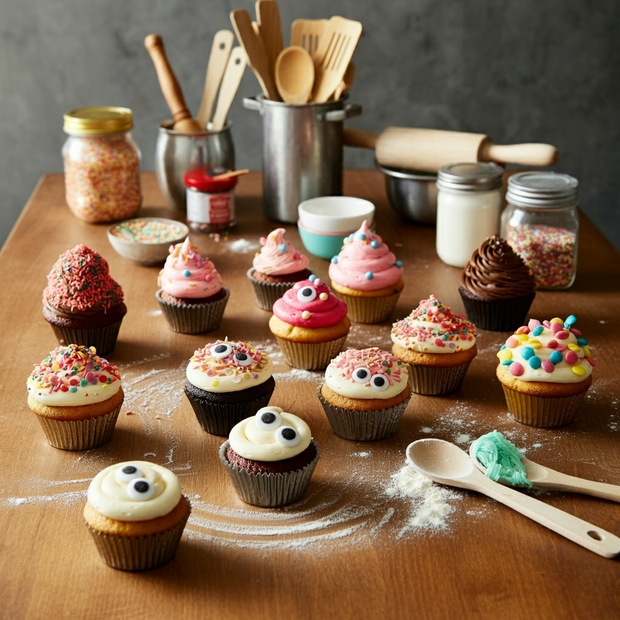

In [ ]:
image = "Cupcakes.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}

im = Image.open(image)
im.thumbnail([620,620], Image.Resampling.LANCZOS)
im

Let's start with a simple prompt to find all items in the image.

To prevent the model from repeating itself, it is recommended to use a temperature over 0, in this case 0.5. Limiting the number of items (25 in the systemp instructions) is also a way to prevent the model from looping and to speed up the decoding of the bounding boxes. You can experiment with these parameters and find what works best for your use-case.

In [ ]:
prompt = "Detect the 2d bounding boxes of the cupcakes (with “label” as topping description”)"  # @param {type:"string"}

# Load and resize image
im = Image.open(BytesIO(open(image, "rb").read()))
im.thumbnail([1024,1024], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Check output
print(response.text)

```json
[
  {"box_2d": [652, 351, 815, 525], "label": "White frosting with googly eyes"},
  {"box_2d": [423, 434, 596, 568], "label": "Pink frosting with googly eyes"},
  {"box_2d": [512, 796, 692, 954], "label": "White frosting with colorful candies"},
  {"box_2d": [389, 735, 535, 862], "label": "Chocolate frosting"},
  {"box_2d": [547, 300, 696, 446], "label": "White frosting with googly eyes and sprinkles"},
  {"box_2d": [489, 623, 638, 771], "label": "White frosting with sprinkles"},
  {"box_2d": [543, 40, 728, 198], "label": "White frosting with colorful sprinkles"},
  {"box_2d": [391, 62, 567, 203], "label": "Chocolate frosting with red sprinkles"},
  {"box_2d": [347, 529, 503, 650], "label": "Pink frosting with blue candies"},
  {"box_2d": [371, 407, 496, 503], "label": "Pink frosting"},
  {"box_2d": [375, 251, 539, 375], "label": "Pink frosting with sprinkles"},
  {"box_2d": [742, 137, 926, 310], "label": "White frosting with googly eyes"},
  {"box_2d": [550, 517, 714, 667], "l

As you can see, even without any instructions about the format, Gemini is trained to always use this format with a label and the coordinates of the bounding box in a "box_2d" array.

Just be careful, the y coordinates are first, x ones afterwards contrary to common usage.

(1024, 1024)


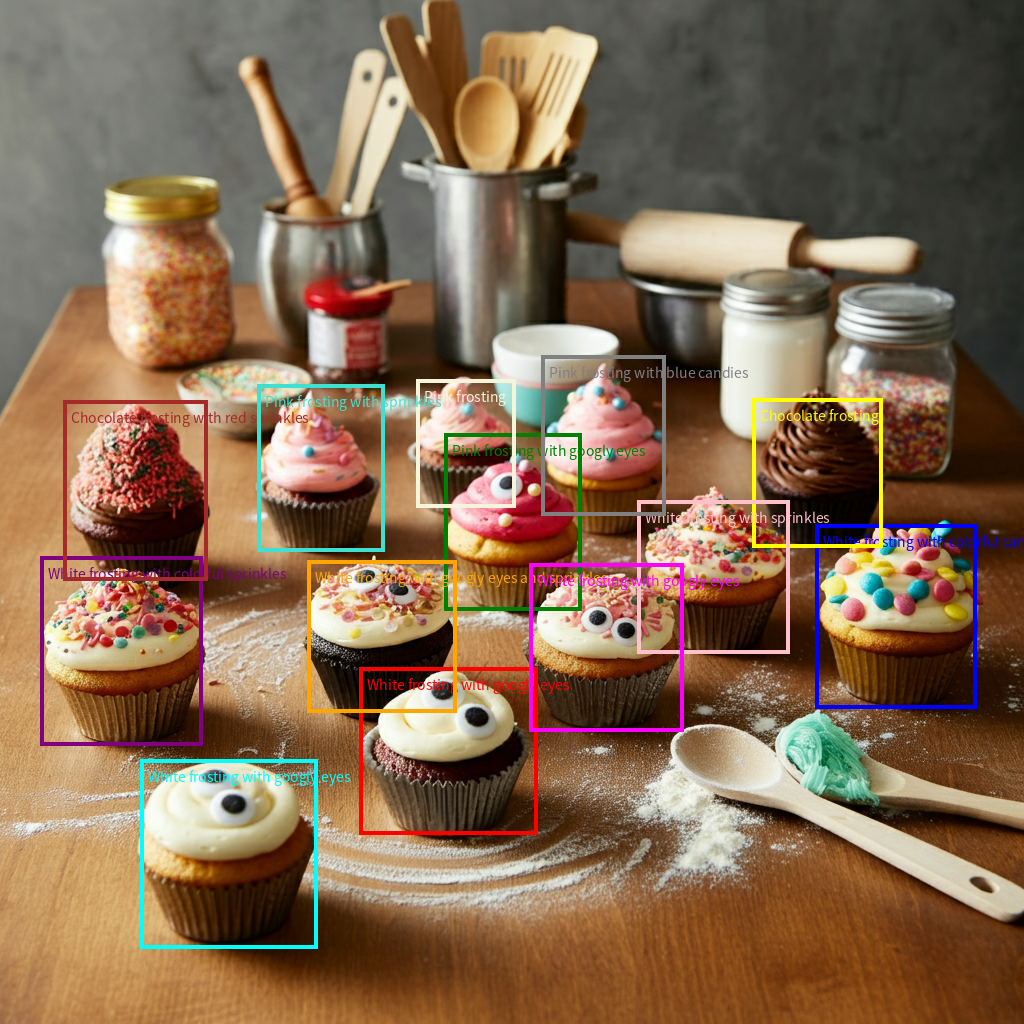

In [ ]:
plot_bounding_boxes(im, response.text)
im

## Search within an image

Let's complicate things and search within the image for specific objects.

Here are the bounding box detections:
```json
[
  {"box_2d": [54, 248, 387, 526], "label": "sock with face"},
  {"box_2d": [235, 659, 652, 862], "label": "sock with face"}
]
```
(640, 482)


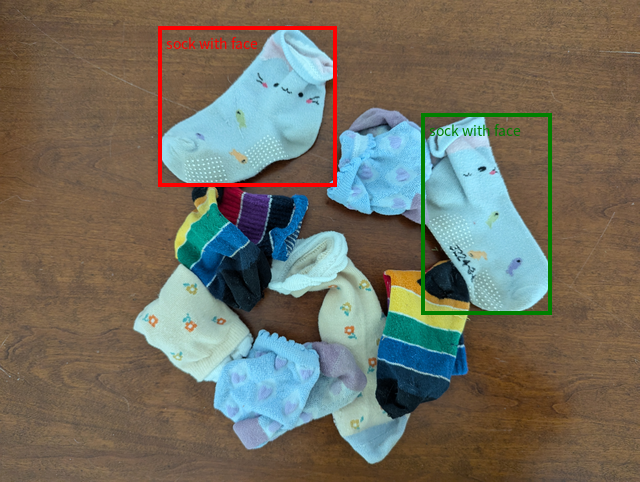

In [ ]:
image = "Socks.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Show me the positions of the socks with the face"  # @param ["Detect all rainbow socks", "Find all socks and label them with emojis ", "Show me the positions of the socks with the face","Find the sock that goes with the one at the top"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Check output
print(response.text)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

Try it with different images and prompts. Different samples are proposed but you can also write your own.

## Multilinguality

As Gemini is able to understand multiple languages, you can combine spatial reasoning with multilingual capabilities.

You can give it an image like this and prompt it to label each item with Japanese characters and English translation. The model reads the text and recognize the pictures from the image itself and translates them.

(640, 640)


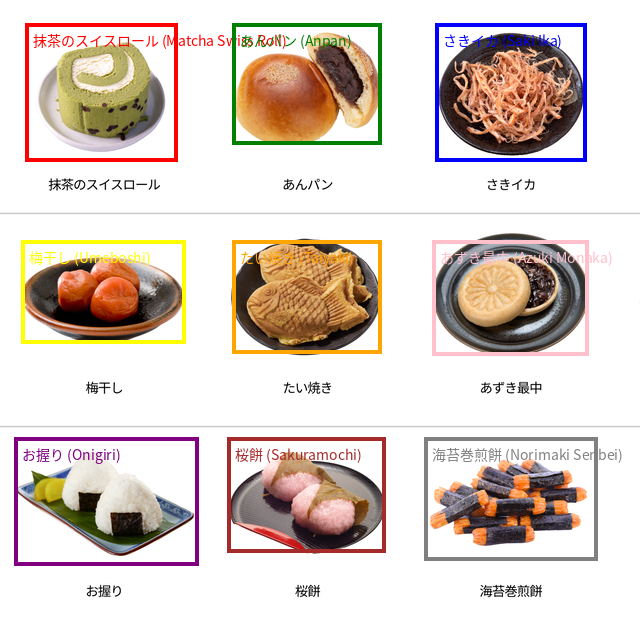

In [ ]:
image = "Japanese_bento.png" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Detect food, label them with Japanese characters + english translation."  # @param ["Detect food, label them with Japanese characters + english translation.", "Show me the vegan dishes","Explain what those dishes are with a 5 words description","Find the dishes with allergens and label them accordingly"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

## Use Gemini reasoning capabilities

The model can also reason based on the image, you can ask it about the positions of items, their utility, or, like in this example, to find the shadow of a speficic item.

(640, 482)


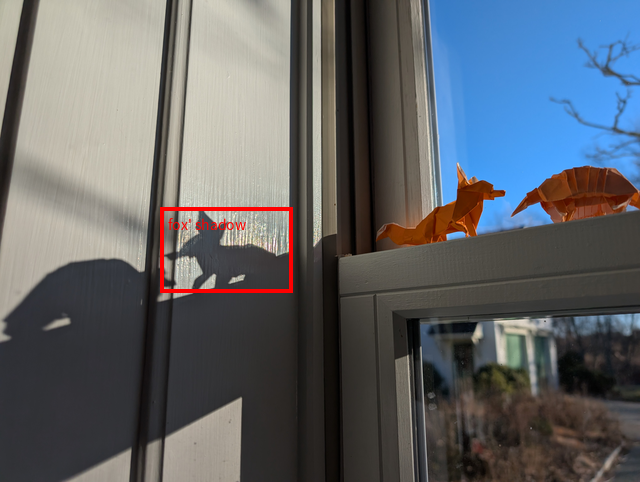

In [ ]:
image = "Origamis.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Draw a square around the fox' shadow"  # @param ["Find the two origami animals.", "Where are the origamis' shadows?","Draw a square around the fox' shadow"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

You can also use Gemini knowledge to enhanced the labels returned. In this example Gemini will give you advices on how to fix your little mistake.

As you can see this time, you're only resizing the image to 1024px as it helps the model getting the bigger picture adn give you advices. There's no clear rule about when to do it, experiment and find what works the best for you.

In [ ]:
image = "beershop.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Extract structured data from this transport pass document and convert it into JSON format. Ensure all fields are accurately captured with correct mappings and data types. Maintain consistency in structure, formatting, and field names. The JSON should follow this structure:\n\n\
{\n\
  \"form\": \"F.L. 1-A\",\n\
  \"transport_pass_no\": \"<Transport Pass Number>\",\n\
  \"date\": \"<Date in DD-MMM-YYYY format>\",\n\
  \"transporter\": {\n\
    \"name\": \"<Transporter Name>\",\n\
    \"address\": \"<Transporter Address>\",\n\
    \"licence_number\": \"<Licence Number>\"\n\
  },\n\
  \"liquor_details\": [\n\
    {\n\
      \"sr_no\": <Serial Number>,\n\
      \"name\": \"<Liquor Name and Brand>\",\n\
      \"strength_vv\": \"<Alcohol Strength in %>\",\n\
      \"size_ml\": <Bottle Size in mL>,\n\
      \"mrp\": <MRP Approved>,\n\
      \"approved_no_cases\": <No of Cases>,\n\
      \"no_bottles\": <No of Bottles>,\n\
      \"total_bottles\": <Total Bottles>,\n\
      \"batch_number\": \"<Batch Number>\",\n\
      \"month_mfg\": \"<Month & Year of Manufacturing>\"\n\
    }\n\
  ],\n\
  \"total\": {\n\
    \"approved_cases\": <Total Approved Cases>,\n\
    \"no_bottles\": <Total No of Bottles>,\n\
    \"total_bottles\": <Total Bottles>\n\
  },\n\
  \"transport_details\": {\n\
    \"destination\": \"<Destination>\",\n\
    \"route\": \"<Transport Route>\",\n\
    \"purpose\": \"<Purpose of Transport>\",\n\
    \"from\": {\n\
      \"name\": \"<Source Name>\",\n\
      \"licence\": \"<Source Licence Number>\",\n\
      \"address\": \"<Source Address>\"\n\
    },\n\
    \"valid_upto\": \"<Valid Until Date>\"\n\
  },\n\
  \"driver\": {\n\
    \"name\": \"<Driver Name>\",\n\
    \"license_no\": \"<Driver License Number>\",\n\
    \"vehicle_no\": \"<Vehicle Number>\",\n\
    \"mobile_no\": \"<Driver Mobile Number>\"\n\
  }\n\
}\n\n\
Strictly adhere to this format. Dates should be in 'DD-MMM-YYYY' format. Numeric values should not be enclosed in quotes. Exclude empty fields. Tables should be extracted as arrays in 'liquor_details'. Ensure correct mappings for transporter, driver, and transport details."

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Generate image with bounding boxes
print(response.text)


```json
{
  "form": "F.L. 1-A",
  "transport_pass_no": "16147/16-Mar-2022 (FL182-160322/16147]",
  "date": "16-Mar-2022",
  "transporter": {
    "name": "SHELKE BEER SHOPEE",
    "address": "Btsmsingh nagar, Nanded city, Tah. Dist. Nanded",
    "licence_number": "FL.BR.2/171"
  },
  "liquor_details": [
    {
      "sr_no": 1,
      "name": "Carlsberg Strong Beer",
      "strength_vv": "8.0%",
      "size_ml": 650,
      "mrp": 210.00,
      "approved_no_cases": 3.00,
      "no_bottles": 0.00,
      "total_bottles": 36.00,
      "batch_number": "907",
      "month_mfg": "Feb-2022"
    },
    {
      "sr_no": 2,
      "name": "Carlsberg Strong Beer",
      "strength_vv": "8.0%",
      "size_ml": 650,
      "mrp": 210.00,
      "approved_no_cases": 2.00,
      "no_bottles": 0.00,
      "total_bottles": 24.00,
      "batch_number": "107",
      "month_mfg": "Feb-2022"
    },
    {
      "sr_no": 3,
      "name": "Tuborg Classic Black Gold Beer",
      "strength_vv": "8.0%",
      "size_ml"

In [ ]:
image = "/content/pic_beer_shop.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = """Instruction:
"Extract structured data from the provided beer stock management sheet and convert it into a strict JSON format. Follow this exact structure:"

JSON Structure to Follow:
json
Copy
Edit
{
  "brand_name": [
    {
      "name": "<BEER_NAME>",
      "size": "<SIZE>",
      "opening_stock": "<OPENING_STOCK>",
      "received_stock": "<RECEIVED_STOCK>",
      "total_stock": "<TOTAL_STOCK>",
      "sales": "<SALES>",
      "closing_stock": "<CLOSING_STOCK>"
    }
    // Repeat for all strong beer entries
  ],
  "mild_beer": [
    {
      "name": "<BEER_NAME>",
      "size": "<SIZE>",
      "opening_stock": "<OPENING_STOCK>",
      "received_stock": "<RECEIVED_STOCK>",
      "total_stock": "<TOTAL_STOCK>",
      "sales": "<SALES>",
      "closing_stock": "<CLOSING_STOCK>"
    }
    // Repeat for all mild beer entries
  ],
  "total_sales": "<TOTAL_SALES>"
}"""

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Generate image with bounding boxes
print(response.text)


NameError: name 'Image' is not defined

And if you check the previous examples, the [Japanese food](#scrollTo=tvVSSr7z3uN4) one in particular,multiple other prompt samples are provided to experiment with Gemini reasoning capabilities.

## Preliminary capabilities: pointing and 3D boxes

Pointing and 3D bounding boxes are experimental model capabilities. Check this [other notebook](../examples/Spatial_understanding_3d.ipynb) to get a sneak peek on those upcoming capabilities.

<a href="../examples/Spatial_understanding_3d.ipynb"><img src="https://storage.googleapis.com/generativeai-downloads/images/box_3d.png" height="400"/></a>

## What's next?

For a more end-to-end example, the code from the [AI Studio Spatial understanding example](https://aistudio.google.com/starter-apps/spatial)  is available on [Github](https://github.com/google-gemini/starter-applets/tree/main/spatial).

You'll also find multiple other examples of Gemini 2.0 capabilities in the [Gemini 2.0 cookbook](https://github.com/google-gemini/cookbook/tree/main/gemini-2/), in particular the [Live API](./Get_started_LiveAPI.ipynb) and the [video understanding](./Video_understanding.ipynb) one.

Related to image recognition and reasoning, [Market a jet backpack](../examples/Market_a_Jet_Backpack.ipynb) and [Guess the shape](../examples/Guess_the_shape.ipynb) examples are worth checking to continue your Gemini API discovery (Note: these examples still use the old SDK). And of course the [pointing and 3d boxes](../examples/Spatial_understanding_3d.ipynb) example referenced earlier.

In [13]:
import pandas as pd
import json

# Load your Excel file
df = pd.read_excel("/content/barcode_number_sku_api-1oo skus.xlsx")

# Filter rows where category is exactly "Food, Beverages & Tobacco"
filtered_df = df[df['category'] == "Food, Beverages & Tobacco"]

# Template prompt for each item
base_prompt = """
You are given two things:
1. A JSON schema representing a product structure.
2. A raw product metadata JSON response.

Your task is to fill in the product schema using appropriate values from the raw metadata. Map fields like barcode, brand, name, description, manufacturer, category, image, etc., correctly. Infer values such as `unit` from the description or ingredient data if needed. Leave fields blank or default if the data is missing.

Return the filled product schema JSON only.

### Product Schema:
{
  "barcode": "string",
  "sku": "string",
  "name": "string",
  "description": "string",
  "category": "string",
  "image_url": "string",
  "base_cost_price": 0,
  "base_selling_price": 0,
  "brand": "string",
  "manufacturer": "string",
  "weight": "string",
  "unit": "string",
  "tax_category": "string",
  "age_group": "string",
  "ebt": false,
  "has_expiry": false,
  "has_variants": false,
  "is_global": true,
  "is_active": true
}

### Product Metadata:
{raw_json}
"""

# Convert each row's raw_jsonb column into a prompt and call the model
results = []

for index, row in filtered_df.iterrows():
    try:
        raw_json = json.loads(row['raw_jsonb'])  # Parse raw_jsonb field
        prompt = base_prompt.replace("{raw_json}", json.dumps(raw_json))

        # Run model
        response = client.models.generate_content(
            model=model_name,
            contents=[prompt],
            config=types.GenerateContentConfig(
                system_instruction=bounding_box_system_instructions,
                temperature=0.5,
                safety_settings=safety_settings,
            )
        )

        # Save the JSON output from the response
        results.append(json.loads(response.text))  # Assuming model returns clean JSON
    except Exception as e:
        print(f"Error at row {index}: {e}")

# Final output list of all JSONs
with open("filled_products.json", "w") as f:
    json.dump(results, f, indent=2)

print("Saved filled product schema responses to filled_products.json")


Error at row 0: Expecting value: line 1 column 1 (char 0)
Error at row 1: Expecting value: line 1 column 1 (char 0)
Error at row 3: Expecting value: line 1 column 1 (char 0)
Error at row 4: Expecting value: line 1 column 1 (char 0)
Error at row 5: Expecting value: line 1 column 1 (char 0)
Error at row 6: Expecting value: line 1 column 1 (char 0)
Error at row 7: Expecting value: line 1 column 1 (char 0)
Error at row 8: Expecting value: line 1 column 1 (char 0)
Error at row 9: Expecting value: line 1 column 1 (char 0)
Error at row 10: Expecting value: line 1 column 1 (char 0)
Error at row 11: Expecting value: line 1 column 1 (char 0)
Error at row 26: Expecting value: line 1 column 1 (char 0)
Error at row 27: Expecting value: line 1 column 1 (char 0)
Error at row 28: Expecting value: line 1 column 1 (char 0)
Error at row 29: Expecting value: line 1 column 1 (char 0)
Error at row 30: Expecting value: line 1 column 1 (char 0)
Error at row 33: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 

In [ ]:
import pandas as pd
import json

# Load the Excel file
file_path = "/content/barcode_number_sku_api-1oo skus.xlsx"
df = pd.read_excel(file_path)

# List to hold normalized JSON objects
normalized_json_list = []

# Loop through each row and parse raw_jsonb
for index, row in df.iterrows():
    raw_data = row.get('raw_jsonb', '')

    try:
        parsed_json = json.loads(raw_data.strip())

        # If 'products' key exists and it's a list, flatten the first product into top level
        if isinstance(parsed_json, dict) and 'products' in parsed_json and isinstance(parsed_json['products'], list):
            product_data = parsed_json['products'][0] if parsed_json['products'] else {}
            normalized_json_list.append(product_data)
            print(product_data)
        else:
            # Use as is
            normalized_json_list.append(parsed_json)

    except json.JSONDecodeError as e:
        print(f"❌ JSONDecodeError at row {index+2}: {e}")
    except Exception as e:
        print(f"❌ Error at row {index+2}: {e}")

# Now convert to DataFrame if needed
normalized_df = pd.json_normalize(normalized_json_list)

# Save to CSV if desired
normalized_df.to_csv("normalized_output.csv", index=False)

#print(f"\n✅ Parsed and normalized {len(normalized_json_list)} JSON objects.")


In [16]:
import pandas as pd
import json

# Load Excel
file_path = "/content/barcode_number_sku_api-1oo skus.xlsx"
df = pd.read_excel(file_path)

# Filter rows where category is exactly "Food, Beverages & Tobacco"
filtered_df = df[df['category'].str.strip() == "Food, Beverages & Tobacco"]

# List to hold parsed JSONs
parsed_json_list = []

# Loop over filtered rows and parse JSON
for index, row in filtered_df.iterrows():
    raw_data = row.get('raw_jsonb', '')

    try:
        parsed_json = json.loads(raw_data.strip())
        parsed_json_list.append(parsed_json)
    except json.JSONDecodeError as e:
        print(f"❌ JSONDecodeError at row {index+2}: {e}")
    except Exception as e:
        print(f"❌ Error at row {index+2}: {e}")

print(f"\n✅ Parsed {len(parsed_json_list)} valid JSONs in 'Food, Beverages & Tobacco' category.")



✅ Parsed 44 valid JSONs in 'Food, Beverages & Tobacco' category.


In [ ]:
import json
from vertexai.preview.generative_models import GenerativeModel, Part
from vertexai.preview import generative_models

# Use your model


# System instruction (optional, tweak if needed)
bounding_box_system_instructions = "You are a helpful assistant for formatting product metadata."

# Your product schema
product_schema = {
    "barcode": "string",
    "sku": "string",
    "name": "string",
    "description": "string",
    "category": "string",
    "image_url": "string",
    "base_cost_price": 0,
    "base_selling_price": 0,
    "brand": "string",
    "manufacturer": "string",
    "weight": "string",
    "unit": "string",
    "tax_category": "string",
    "age_group": "string",
    "ebt": False,
    "has_expiry": False,
    "has_variants": False,
    "is_global": True,
    "is_active": True
}

# Store all model outputs here
final_outputs = []

for i, raw_metadata in enumerate(parsed_json_list):
    try:
        prompt = f"""
You are given two things:
1. A JSON schema representing a product structure.
2. A raw product metadata JSON response.

Your task is to fill in the product schema using appropriate values from the raw metadata. Map fields like barcode, brand, name, description, manufacturer, category, image, etc., correctly. Infer values such as `unit` from the description or ingredient data if needed. Leave fields blank or default if the data is missing.

Return the filled product schema JSON only.

### Product Schema:
{json.dumps(product_schema, indent=2)}

### Product Metadata:
{json.dumps(raw_metadata, indent=2)}
"""

        response = model.generate_content(
            contents=prompt,
            generation_config=generative_models.GenerationConfig(
                temperature=0.5
            ),
        )

        generated_json = response.text.strip()
        print(f"\n✅ Response {i+1}:\n{generated_json}\n")

        # Save to list
        final_outputs.append(json.loads(generated_json))

    except Exception as e:
        print(f"❌ Error processing item {i+1}: {e}")

# Optional: save all responses to a JSON file
with open("filled_product_schemas.json", "w") as f:
    json.dump(final_outputs, f, indent=2)

print(f"\n🎯 Done! Successfully processed {len(final_outputs)} products.")


In [20]:
import json

# To store final responses
final_outputs = []

# Schema to include in the prompt
product_schema_template = {
    "barcode": "string",
    "sku": "string",
    "name": "string",
    "description": "string",
    "category": "string",
    "image_url": "string",
    "base_cost_price": 0,
    "base_selling_price": 0,
    "brand": "string",
    "manufacturer": "string",
    "weight": "string",
    "unit": "string",
    "tax_category": "string",
    "age_group": "string",
    "ebt": False,
    "has_expiry": False,
    "has_variants": False,
    "is_global": True,
    "is_active": True
}

# Loop through all parsed JSONs from earlier step
for i, raw_json in enumerate(parsed_json_list):
    try:
        prompt = f"""You are given two things:
1. A JSON schema representing a product structure.
2. A raw product metadata JSON response.

Your task is to fill in the product schema using appropriate values from the raw metadata. Map fields like barcode, brand, name, description, manufacturer, category, image, etc., correctly. Infer values such as `unit` from the description or ingredient data if needed. Leave fields blank or default if the data is missing.

Return the filled product schema JSON only.

### Product Schema:
{json.dumps(product_schema_template, indent=2)}

### Product Metadata:
{json.dumps(raw_json, indent=2)}
"""

        # Make API call
        response = client.models.generate_content(
            model=model_name,
            contents=[prompt],
            config=types.GenerateContentConfig(
                system_instruction=bounding_box_system_instructions,
                temperature=0.5,
                safety_settings=safety_settings,
            )
        )

        # Collect and parse model output
        result_json = json.loads(response.text.strip())
        final_outputs.append(result_json)

        print(f"✅ Done [{i+1}/{len(parsed_json_list)}]")

    except Exception as e:
        print(f"❌ Error at item {i+1}: {e}")

# Save to file
with open("final_product_schemas.json", "w") as f:
    json.dump(final_outputs, f, indent=2)

print(f"\n🎉 Finished generating {len(final_outputs)} product schemas.")


❌ Error at item 1: 404 NOT_FOUND. {'error': {'code': 404, 'message': 'models/gemini-1.0-pro-vision is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.', 'status': 'NOT_FOUND'}}
❌ Error at item 2: 404 NOT_FOUND. {'error': {'code': 404, 'message': 'models/gemini-1.0-pro-vision is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.', 'status': 'NOT_FOUND'}}
❌ Error at item 3: 404 NOT_FOUND. {'error': {'code': 404, 'message': 'models/gemini-1.0-pro-vision is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.', 'status': 'NOT_FOUND'}}
❌ Error at item 4: 404 NOT_FOUND. {'error': {'code': 404, 'message': 'models/gemini-1.0-pro-vision is not found for API version v1beta, or is not su

In [38]:
import json
import time
import random

# Use the Gemini 2.0 Flash model
model_name = "gemini-2.0-flash"

# Product schema template
product_schema_template = {
    "barcode": "string",
    "sku": "string",
    "name": "string",
    "description": "string",
    "category": "string",
    "image_url": "string",
    "base_cost_price": 0,
    "base_selling_price": 0,
    "brand": "string",
    "manufacturer": "string",
    "weight": "string",
    "unit": "string",
    "tax_category": "string",
    "age_group": "string",
    "ebt": False,
    "has_expiry": False,
    "has_variants": False,
    "is_global": True,
    "is_active": True
}

# Store filled product schemas
final_outputs = []

# Save function to dump intermediate results
def save_progress(data, filename="product_outputs.json"):
    with open(filename, "w") as f:
        json.dump(data, f, indent=2)

# Retry settings
max_retries = 5

# Resume from item 34 (index 33)
for i, raw_json in enumerate(normalized_json_list[33:], start=34):
    try:
        print(raw_json)

        if raw_json.get("category") != "Food, Beverages & Tobacco":
            continue

        prompt = f"""You are given two things:
1. A JSON schema representing a product structure.
2. A raw product metadata JSON response.

Your task is to fill in the product schema using appropriate values from the raw metadata. Map fields like barcode, brand, name, description, manufacturer, category, image, etc., correctly. Infer values such as `unit` from the description or ingredient data if needed. Leave fields blank or default if the data is missing.

Return the filled product schema JSON only.

### Product Schema:
{product_schema_template}

### Product Metadata:
{raw_json}
"""

        # Retry loop
        for attempt in range(max_retries):
            try:
                response = client.models.generate_content(
                    model=model_name,
                    contents=[prompt],
                    config=types.GenerateContentConfig(
                        system_instruction=bounding_box_system_instructions,
                        temperature=0.5,
                        safety_settings=safety_settings,
                    )
                )
                break  # success
            except Exception as e:
                if "429" in str(e):
                    wait_time = 2 ** attempt + random.uniform(0, 1)
                    print(f"⚠️ Rate limit hit at item {i}. Retrying in {wait_time:.1f} seconds...")
                    time.sleep(wait_time)
                else:
                    raise e  # other errors — break outer try

        # Parse response
        result_json = response.text
        final_outputs.append(result_json)

        # Save intermediate result
        save_progress(final_outputs)

        print(f"✅ Processed {i}/{len(normalized_json_list)}")

    except Exception as e:
        print(f"❌ Error at item {i}: {e}")


{'mpn': '', 'asin': '', 'size': '', 'brand': "KERN'S", 'color': '', 'model': '', 'title': 'Apricot Nectar from Concentrate', 'width': '', 'format': '', 'gender': '', 'height': '', 'images': ['https://images.barcodelookup.com/17400/174006424-1.jpg'], 'length': '', 'stores': [], 'weight': '', 'pattern': '', 'reviews': [], 'category': 'Food, Beverages & Tobacco', 'features': [], 'material': '', 'age_group': '', 'multipack': '', 'description': 'Apricot Nectar From Concentrate. Serving size: 1 CAN (340 ml). Country of origin: United States.', 'ingredients': 'Water, Apricot Puree From Concentrate, Sugar, Malic Acid, Natural Flavor, Ascorbic Acid (vitamin C).', 'last_update': '2023-10-22 07:15:27', 'contributors': [], 'manufacturer': '', 'release_date': '', 'barcode_number': '888903201027', 'barcode_formats': 'UPC-A 888903201027, EAN-13 0888903201027', 'nutrition_facts': 'Energy 55.88 kcal, Carbohydrates 14.12 g, Sugars 14.12 g, Salt 0.0523 g, Vitamin C 0.0176 g.', 'energy_efficiency_class': 

In [39]:
import json
import re

# Your original list (shortened here for brevity, replace with your full list)
raw_list = ['```json\n{"barcode": "022652192148", "sku": "", "name": "Aloe Vera Drink", "description": "Aloe Vera Drink. Serving size: 240 ml (240 ml). Country of origin: United States.", "category": "Food, Beverages & Tobacco", "image_url": "", "base_cost_price": 0, "base_selling_price": 0, "brand": "Sun Hing Foods  Inc.", "manufacturer": "Sun Hing Foods, Inc.", "weight": "", "unit": "ml", "tax_category": "", "age_group": "", "ebt": false, "has_expiry": false, "has_variants": false, "is_global": true, "is_active": true}\n```', '```json\n{"barcode": "022652192162", "sku": "", "name": "Aloe Mango", "description": "Aloe mango. Serving size: 240 ml (240 ml). Country of origin: United States.", "category": "Food, Beverages & Tobacco", "image_url": "https://images.barcodelookup.com/9050/90505062-1.jpg", "base_cost_price": 0, "base_selling_price": 0, "brand": "Sun Hing Foods  Inc.", "manufacturer": "Sun Hing Foods, Inc.", "weight": "", "unit": "ml", "tax_category": "", "age_group": "", "ebt": false, "has_expiry": false, "has_variants": false, "is_global": true, "is_active": true}\n```', '```json\n{"barcode": "022652192179", "sku": "", "name": "Aloe Granada", "description": "Aloe Granada. Country of origin: United States.", "category": "Food, Beverages & Tobacco", "image_url": "https://images.barcodelookup.com/81545/815451217-1.jpg", "base_cost_price": 0, "base_selling_price": 0, "brand": "", "manufacturer": "", "weight": "", "unit": "", "tax_category": "", "age_group": "", "ebt": false, "has_expiry": false, "has_variants": false, "is_global": true, "is_active": true}\n```', '```json\n{"barcode": "022652192315", "sku": "", "name": "Aloe Vera Drink", "description": "Aloe Vera Drink. Country of origin: United States.", "category": "Food, Beverages & Tobacco", "image_url": "https://images.barcodelookup.com/81545/815451218-1.jpg", "base_cost_price": 0, "base_selling_price": 0, "brand": "", "manufacturer": "", "weight": "", "unit": "", "tax_category": "", "age_group": "", "ebt": false, "has_expiry": false, "has_variants": false, "is_global": true, "is_active": true}\n```', '```json\n{"barcode": "090478216805", "sku": "", "name": "Mineragua", "description": "Mineragua. Country of origin: Switzerland,United States.", "category": "Food, Beverages & Tobacco", "image_url": "https://images.barcodelookup.com/2973/29734519-1.jpg", "base_cost_price": 0, "base_selling_price": 0, "brand": "Jarritos", "manufacturer": "Jarritos", "weight": "1 ounces", "unit": "liter", "tax_category": "", "age_group": "adult", "ebt": false, "has_expiry": false, "has_variants": false, "is_global": true, "is_active": true}\n```', '```json\n{"barcode": "022652192155", "sku": "", "name": "Aloe Original", "description": "Aloe original. Country of origin: United States.", "category": "Food, Beverages & Tobacco", "image_url": "https://images.barcodelookup.com/81545/815451216-1.jpg", "base_cost_price": 0, "base_selling_price": 0, "brand": "", "manufacturer": "", "weight": "", "unit": "", "tax_category": "", "age_group": "", "ebt": false, "has_expiry": false, "has_variants": false, "is_global": true, "is_active": true}\n```', '```json\n{"barcode": "022652192124", "sku": "", "name": "Aloe Pina", "description": "Aloe pina. Country of origin: United States.", "category": "Food, Beverages & Tobacco", "image_url": "https://images.barcodelookup.com/81545/815451215-1.jpg", "base_cost_price": 0, "base_selling_price": 0, "brand": "", "manufacturer": "", "weight": "", "unit": "", "tax_category": "", "age_group": "", "ebt": false, "has_expiry": false, "has_variants": false, "is_global": true, "is_active": true}\n```', '```json\n{"barcode": "022652192186", "sku": "", "name": "Parrot, Aloe Vera Drink, Coco", "description": "Parrot, Aloe Vera Drink, Coco. Serving size: 240 ml (240 ml). Country of origin: United States.", "category": "Food, Beverages & Tobacco", "image_url": null, "base_cost_price": 0, "base_selling_price": 0, "brand": "Sun Hing Foods  Inc.", "manufacturer": "Sun Hing Foods, Inc.", "weight": "", "unit": "ml", "tax_category": null, "age_group": null, "ebt": false, "has_expiry": false, "has_variants": false, "is_global": true, "is_active": true}\n```', '```json\n{"barcode": "718122297849", "sku": "", "name": "Aloe Vera Drink, Coconut", "description": "Aloe Vera Drink, Coconut. Serving size: 1 cup (240 ml). Country of origin: United States.", "category": "Food, Beverages & Tobacco", "image_url": "https://images.barcodelookup.com/5654/56540333-1.jpg", "base_cost_price": 0, "base_selling_price": 17.99, "brand": "Ad-Visor", "manufacturer": "Ad-Visor", "weight": "1 ounces", "unit": "Liter", "tax_category": "", "age_group": "", "ebt": false, "has_expiry": false, "has_variants": false, "is_global": true, "is_active": true}\n```', '```json\n{"barcode": "090478321103", "sku": "53273958", "name": "Senorial Nonalcoholic Sangria", "description": "Senorial nonalcoholic sangria. Serving size: 8 OZA (240 ml). Country of origin: United States.", "category": "Food, Beverages & Tobacco", "image_url": "https://images.barcodelookup.com/3147/31473280-1.jpg", "base_cost_price": 0, "base_selling_price": 1.26, "brand": "Jarritos  Inc.", "manufacturer": "Tipp Distributors  Inc.", "weight": "1 ounces", "unit": "bottle", "tax_category": "", "age_group": "", "ebt": false, "has_expiry": false, "has_variants": false, "is_global": true, "is_active": true}\n```', '```json\n{"barcode": "851538002840", "sku": "", "name": "Classic Margarita", "description": "Classic Margarita. Country of origin: United States.", "category": "Food, Beverages & Tobacco", "image_url": "https://images.barcodelookup.com/81678/816787613-1.jpg", "base_cost_price": 0, "base_selling_price": 0, "brand": "", "manufacturer": "", "weight": "", "unit": "", "tax_category": "", "age_group": "", "ebt": false, "has_expiry": false, "has_variants": false, "is_global": true, "is_active": true}\n```', '```json\n{"barcode": "015800030614", "sku": "21558970", "name": "C&H Premium Pure Cane Granulated Sugar  10 Lb", "description": "C&H Premium Pure Cane Granulated Sugar 10 lb Make your day a little sweeter with C&H Granulated Sugar. We refine our sugar into extra fine crystals so you can easily stir it sprinkle it or mix it into recipes. Whether you re baking cooking or adding it to your favorite drinks you ll find C&H Granulated Sugar will be perfect for your next delicious moment. Visit www.chsugar.com for delicious recipes.", "category": "Food, Beverages & Tobacco", "image_url": "https://images.barcodelookup.com/2966/29669945-1.jpg", "base_cost_price": 0, "base_selling_price": 6.89, "brand": "C&H", "manufacturer": "Domino Foods  Inc.", "weight": "10", "unit": "lb", "tax_category": "", "age_group": "", "ebt": false, "has_expiry": false, "has_variants": false, "is_global": true, "is_active": true}\n```', '```json\n{"barcode": "041508992688", "sku": "", "name": "Aranciata Rossa", "description": "Aranciata Rossa. Country of origin: United States.", "category": "Food, Beverages & Tobacco", "image_url": "https://images.barcodelookup.com/32331/323315034-1.jpg", "base_cost_price": 0, "base_selling_price": 0, "brand": "Sanpellegrino", "manufacturer": "San Pellegrino", "weight": "", "unit": "oz", "tax_category": "", "age_group": "", "ebt": false, "has_expiry": false, "has_variants": false, "is_global": true, "is_active": true}\n```', '```json\n{"barcode": "071230021042", "sku": "", "name": "Farm Fresh Eggs", "description": "Farm Fresh Eggs. Serving size: 1 EGG (44 g). Country of origin: United States.", "category": "Food, Beverages & Tobacco", "image_url": "https://images.barcodelookup.com/17398/173980854-1.jpg", "base_cost_price": 0, "base_selling_price": 0, "brand": "NULAID", "manufacturer": "", "weight": "", "unit": "g", "tax_category": "", "age_group": "", "ebt": false, "has_expiry": false, "has_variants": false, "is_global": true, "is_active": true}\n```', '```json\n{"barcode": "041508265089", "sku": "0041508265089", "name": "Sanpellegrino Limonata", "description": "Sanpellegrino limonata. Country of origin: United States.", "category": "Food, Beverages & Tobacco", "image_url": "https://images.barcodelookup.com/58864/588647396-1.jpg", "base_cost_price": 0, "base_selling_price": 0, "brand": "Sanpellegrino", "manufacturer": "San Pellegrino", "weight": "", "unit": "Fl Oz", "tax_category": "", "age_group": "", "ebt": false, "has_expiry": false, "has_variants": false, "is_global": true, "is_active": true}\n```', '```json\n{"barcode": "042743230788", "sku": "", "name": "Tomatillos Enteros", "description": "Tomatillos Enteros. Serving size: 100 g. Country of origin: Mexico.", "category": "Food, Beverages & Tobacco", "image_url": "https://images.barcodelookup.com/3147/31477097-1.jpg", "base_cost_price": 0, "base_selling_price": 0, "brand": "EL MEXICANO", "manufacturer": "Marquez Bros.", "weight": "767 g", "unit": "g", "tax_category": "", "age_group": "", "ebt": false, "has_expiry": false, "has_variants": false, "is_global": true, "is_active": true}\n```']



# Step 1: Clean and parse each JSON string
cleaned_data = []
for item in final_outputs:
    match = re.search(r'```json\n(.*)\n```', item, re.DOTALL)
    if match:
        json_str = match.group(1)
        try:
            data = json.loads(json_str)
            cleaned_data.append(data)
        except json.JSONDecodeError as e:
            print(f"Failed to parse item: {e}")

# Step 2: Save to a JSON file
with open("products.json", "w") as f:
    json.dump(cleaned_data, f, indent=4)

print("JSON data has been written to products.json")


JSON data has been written to products.json


In [40]:
########## final stage for the data cleaning or lets say to the processing of the data

In [ ]:







import json
import random

# Your raw JSON string (just an example, paste the full string here)
json_string = '''
[
  {
    "barcode": "22652192148",
    "sku": "22652192148",
    "name": "Aloe Vera Drink",
    "description": "Aloe Vera Drink",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://pos-image-product.s3.us-east-2.amazonaws.com/products/Cucumber.png",
    "base_cost_price": "4.2",
    "base_selling_price": "4.8",
    "brand": "Dabur",
    "manufacturer": "Dabur",
    "weight": "100",
    "unit": "ml",
    "tax_category": "67e917e52395a84e504830bb",
    "age_group": null,
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67ef8c089b2f49ef11aff77f"
  },
  {
    "barcode": "851538002499",
    "sku": "AUTO-GEN-851538002499",
    "name": "Crush Cucumber Sour Ale",
    "description": "10 Barrel Brewing Co. Crush Cucumber Sour Ale, 12 fl. oz. Can.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/19512/195121619-1.jpg",
    "base_cost_price": "15.0",
    "base_selling_price": "15.0",
    "brand": "10 Barrel Brewing Co.",
    "manufacturer": "10 Barrel Brewing Co.",
    "weight": "250",
    "unit": "ml",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f1111b36ece0995c7d3672"
  },
  {
    "barcode": "082896002733",
    "sku": "082896002733",
    "name": "Red Wine - California",
    "description": "A blend of select Cabernet lots; flavors of cherry, currant, graphite, charred vanilla, and dried herbs.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/20835/208358941-1.jpg",
    "base_cost_price": "15.99",
    "base_selling_price": "21.99",
    "brand": "1000 Stories",
    "manufacturer": "1000 Stories",
    "weight": "750",
    "unit": "ml",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "21+",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f1135a36ece0995c7d3673"
  },
  {
    "barcode": "082896002849",
    "sku": "957907",
    "name": "Aged Chardonnay",
    "description": "The explorers who ventured to the American West in the late 1800s sought new beginnings and prosperity. 1000 Stories Bourbon Barrel-Aged Chardonnay honors their grit and determination, and the legacy they left. Look for hallmark bourbon barrel notes of charred vanilla, dried herbs and toasted caramel.Wine of California, USA, Bourbon Barrel-Aged.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/24291/242914672-1.jpg",
    "base_cost_price": "13.0",
    "base_selling_price": "16.99",
    "brand": "1000 Stories",
    "manufacturer": "1000 Stories",
    "weight": "1",
    "unit": "ltr",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f1139736ece0995c7d3674"
  },
  {
    "barcode": "082896003655",
    "sku": "957908",
    "name": "Aged Pinot Noir 2020 Red Wine - California",
    "description": "Made with a uniquely American perspective, 1000 Stories is crafted to push boundaries. Each batch of this bold Pinot Noir brings distinct notes of wild cherry, black raspberry and vanilla. These deepen alongside hints of earth and allspice from.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/53286/532861263-1.jpg",
    "base_cost_price": "13.0",
    "base_selling_price": "16.99",
    "brand": "1000 Stories",
    "manufacturer": "1000 Stories",
    "weight": "750",
    "unit": "ml",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f113a936ece0995c7d3675"
  },
  {
    "barcode": "022652192148",
    "sku": "022652192148",
    "name": "Aloe Vera Drink",
    "description": "Aloe Vera Drink. Serving size: 240 ml. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "",
    "base_cost_price": "1",
    "base_selling_price": "3",
    "brand": "Sun Hing Foods, Inc.",
    "manufacturer": "Sun Hing Foods, Inc.",
    "weight": "250",
    "unit": "ml",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f1146336ece0995c7d3676"
  },
  {
    "barcode": "022652192162",
    "sku": "022652192162",
    "name": "Aloe Mango",
    "description": "Aloe Mango flavored aloe vera drink. Serving size: 240 ml. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/9050/90505062-1.jpg, https://images.barcodelookup.com/9050/90505062-2.jpg",
    "base_cost_price": "1",
    "base_selling_price": "2.99",
    "brand": "Sun Hing Foods, Inc.",
    "manufacturer": "Sun Hing Foods, Inc.",
    "weight": "250",
    "unit": "ml",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f1147136ece0995c7d3677"
  },
  {
    "barcode": "078000011814",
    "sku": "078000011814",
    "name": "Zero Sugar 7-up Soda",
    "description": "Enjoy the crisp, clean, refreshing lemon-lime taste of 7-Up 100% natural flavors - stripped of artificial flavors and preservatives. And no caffeine! Not available in all areas. Quantity may be delivered as two 12-packs instead of one 24-pack.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/1976/19760079-1.jpg",
    "base_cost_price": "3",
    "base_selling_price": "4.99",
    "brand": "7-Up",
    "manufacturer": "7-Up",
    "weight": "1.00 lb",
    "unit": "fl oz",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f1149136ece0995c7d3678"
  },
  {
    "barcode": "022652192179",
    "sku": "022652192179",
    "name": "Aloe Granada",
    "description": "Aloe Granada. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/81545/815451217-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "",
    "manufacturer": "",
    "weight": "",
    "unit": "",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f114a436ece0995c7d3679"
  },
  {
    "barcode": "022652192315",
    "sku": "022652192315",
    "name": "Aloe Vera Drink",
    "description": "Aloe Vera Drink. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/81545/815451218-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "",
    "manufacturer": "",
    "weight": "",
    "unit": "",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f115b936ece0995c7d367a"
  },
  {
    "barcode": "090478216805",
    "sku": "090478216805",
    "name": "Mineragua",
    "description": "Mineragua. Country of origin: Switzerland,United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/2973/29734519-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Jarritos",
    "manufacturer": "Jarritos",
    "weight": "1 ounces",
    "unit": "liter",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f12259da6bd655f7b48f94"
  },
  {
    "barcode": "022652192155",
    "sku": "022652192155",
    "name": "Aloe Original",
    "description": "Aloe original. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/81545/815451216-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "",
    "manufacturer": "",
    "weight": "",
    "unit": "",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f12259da6bd655f7b48f95"
  },
  {
    "barcode": "022652192124",
    "sku": "022652192124",
    "name": "Aloe Pina",
    "description": "Aloe pina. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/81545/815451215-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "",
    "manufacturer": "",
    "weight": "",
    "unit": "",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f122ccda6bd655f7b48f96"
  },
  {
    "barcode": "022652192186",
    "sku": "022652192186",
    "name": "Parrot, Aloe Vera Drink, Coco",
    "description": "Parrot, Aloe Vera Drink, Coco. Serving size: 240 ml (240 ml). Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Sun Hing Foods Inc.",
    "manufacturer": "Sun Hing Foods, Inc.",
    "weight": "",
    "unit": "ml",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f122ccda6bd655f7b48f97"
  },
  {
    "barcode": "718122297849",
    "sku": "718122297849",
    "name": "Aloe Vera Drink, Coconut",
    "description": "Aloe Vera Drink, Coconut. Serving size: 1 cup (240 ml). Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/5654/56540333-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Ad-Visor",
    "manufacturer": "Ad-Visor",
    "weight": "1 ounces",
    "unit": "liter",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f122ccda6bd655f7b48f98"
  },
  {
    "barcode": "090478321103",
    "sku": "090478321103",
    "name": "Senorial Nonalcoholic Sangria",
    "description": "Senorial nonalcoholic sangria. Serving size: 8 OZA (240 ml). Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/3147/31473280-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Jarritos Inc.",
    "manufacturer": "Tipp Distributors Inc.",
    "weight": "1 ounces",
    "unit": "liter",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f122ccda6bd655f7b48f99"
  },
  {
    "barcode": "851538002840",
    "sku": "851538002840",
    "name": "Classic Margarita",
    "description": "Classic Margarita. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/81678/816787613-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "",
    "manufacturer": "",
    "weight": "",
    "unit": "liter",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f122ccda6bd655f7b48f9a"
  },
  {
    "barcode": "810023700302",
    "sku": "810023700302",
    "name": "10 Barrel All Ways Down Double IPA Ale - Beer - 6 Pack 12oz Cans",
    "description": "Bursting with juicy, hop-forward flavor, this Double IPA is brewed for those who know there's never a wrong time to send it. Featuring Simcoe, Azacca and Mosaic Cryo Hops, this trifecta is a full-on assault of hop flavor and aroma.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/51691/516914064-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "10 Barrel",
    "manufacturer": "10 Barrel Brewing Co.",
    "weight": "",
    "unit": "liter",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f122ccda6bd655f7b48f9b"
  },
  {
    "barcode": "850162008211",
    "sku": "850162008211",
    "name": "10 Barrel Profuse Juice Hazy IPA 6pk 12oz Can 6.5% ABV",
    "description": "Tropical fruit aromas. Bitter orange, pithy tangerine, vanilla sweetness. Full bodied, pleasant sweet malt flavor.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/13657/136571850-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "10 Barrel",
    "manufacturer": "10 Barrel",
    "weight": "5.3 ounces",
    "unit": "liter",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f122ccda6bd655f7b48f9c"
  },
  {
    "barcode": "850162008617",
    "sku": "850162008617",
    "name": "10 Barrel Brewing Co. Greyhound Ready-to-drink - 12oz Can",
    "description": "The ideal gift! Buy the best ready-to-drink online. Price and reviews available for 10 Barrel Brewing Co. Greyhound Ready-to-drink - 12oz Can. We created a refreshing Greyhound by perfectly blending grapefruit juice, sparkling water and vodka. Canned for your convenience to take anywhere, and recommended to enjoy outside paired with fresh air and sunshine.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/51691/516914742-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "10 Barrel",
    "manufacturer": "10 Barrel Brewing Co.",
    "weight": "",
    "unit": "liter",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f122ccda6bd655f7b48f9d"
  },
  {
    "barcode": "850162008235",
    "sku": "850162008235",
    "name": "10 Barrel Crush Cucumber Sour Weisse 6pk 12oz Can 5.0% ABV",
    "description": "Brewed to appeal to any palate or virgins of the sour craze, this award winning beer is crisp and refreshing. Made for you to crush anywhere, anytimethe time is now, #crushlife.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/13658/136585941-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "10 Barrel",
    "manufacturer": "10 Barrel",
    "weight": "5.3 ounces",
    "unit": "liter",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f122ccda6bd655f7b48f9e"
  },
  {
    "barcode": "9780217123044",
    "sku": "9780217123044",
    "name": "The New Adam by Louis Untermeyer Paperback | Indigo Chapters",
    "description": "This is an OCR edition without illustrations or index. It may have numerous typos or missing text. However, purchasers can download a free scanned copy of the original rare book from GeneralBooksClub. com. You can also preview excerpts from the book there. Purchasers are also entitled to a free trial membership in the General Books Club where they can select from more than a million books without charge. Original Published by: Harcourt, Brace and Howe in 1920 in 153 pages; Subjects: History / General; Poetry / General; Poetry / American / General; Poetry / English, Irish, Scottish, Welsh; | The new Adam by Louis Untermeyer Paperback | Indigo Chapters.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/725/7257701-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Louis Untermeyer",
    "manufacturer": "Louis Untermeyer",
    "weight": "",
    "unit": "liter",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f122ccda6bd655f7b48f9f"
  },
  {
    "barcode": "88004030711",
    "sku": "88004030711",
    "name": " Kentucky Straight Bourbon Whiskey - 750ml Bottle",
    "description": "1792 Bourbon Aged 12 Years Kentucky Straight Bourbon Whiskey - 750ml Bottle",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/24704/247048416-1.jpg",
    "base_cost_price": "20",
    "base_selling_price": "22",
    "brand": "Kentucky Straight",
    "manufacturer": "Kentucky Straight",
    "weight": "0.01lb",
    "unit": "ml",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "18",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3718a63ee5fb891869288"
  },
  {
    "barcode": "0904782168",
    "sku": "0904782168",
    "name": "Mineragua",
    "description": "Mineragua. Country of origin: Switzerland,United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/2973/29734519-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Jarritos",
    "manufacturer": "Jarritos",
    "weight": "1 ounces",
    "unit": "liter",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3aa5f63ee5fb891869289"
  },
  {
    "barcode": "015800030614",
    "sku": "21558970",
    "name": "C&H Premium Pure Cane Granulated Sugar  10 Lb",
    "description": "C&H Premium Pure Cane Granulated Sugar 10 lb Make your day a little sweeter with C&H Granulated Sugar. We refine our sugar into extra fine crystals so you can easily stir it sprinkle it or mix it into recipes. Whether you re baking cooking or adding it to your favorite drinks you ll find C&H Granulated Sugar will be perfect for your next delicious moment. Visit www.chsugar.com for delicious recipes.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/2966/29669945-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "6.89",
    "brand": "C&H",
    "manufacturer": "Domino Foods  Inc.",
    "weight": "10",
    "unit": "lb",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3acc363ee5fb89186928a"
  },
  {
    "barcode": "041508992688",
    "sku": "041508992688",
    "name": "Aranciata Rossa",
    "description": "Aranciata Rossa. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/32331/323315034-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Sanpellegrino",
    "manufacturer": "San Pellegrino",
    "weight": "",
    "unit": "oz",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3acc363ee5fb89186928b"
  },
  {
    "barcode": "071230021042",
    "sku": "071230021042",
    "name": "Farm Fresh Eggs",
    "description": "Farm Fresh Eggs. Serving size: 1 EGG (44 g). Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/17398/173980854-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "NULAID",
    "manufacturer": "",
    "weight": "",
    "unit": "g",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3acc363ee5fb89186928c"
  },
  {
    "barcode": "041508265089",
    "sku": "0041508265089",
    "name": "Sanpellegrino Limonata",
    "description": "Sanpellegrino limonata. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/58864/588647396-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Sanpellegrino",
    "manufacturer": "San Pellegrino",
    "weight": "",
    "unit": "Fl Oz",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3acc363ee5fb89186928d"
  },
  {
    "barcode": "042743230788",
    "sku": "042743230788",
    "name": "Tomatillos Enteros",
    "description": "Tomatillos Enteros. Serving size: 100 g. Country of origin: Mexico.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/3147/31477097-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "EL MEXICANO",
    "manufacturer": "Marquez Bros.",
    "weight": "767 g",
    "unit": "g",
    "tax_category": "67e9171f2395a84e504830ba",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3acc363ee5fb89186928e"
  },
  {
    "barcode": "888903201027",
    "sku": "888903201027",
    "name": "Apricot Nectar from Concentrate",
    "description": "Apricot Nectar From Concentrate. Serving size: 1 CAN (340 ml). Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/17400/174006424-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "KERN'S",
    "manufacturer": "",
    "weight": "",
    "unit": "ml",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb891869291"
  },
  {
    "barcode": "098487960221",
    "sku": "098487960221",
    "name": "12 Grain Loaf",
    "description": "12 Grain loaf. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/81659/816596074-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "",
    "manufacturer": "",
    "weight": "",
    "unit": "oz",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb891869292"
  },
  {
    "barcode": "015900063475",
    "sku": "015900063475",
    "name": "Smoked Deli Style Ham",
    "description": "Smoked Deli Style Ham. Serving size: 1 SLICE (37 g). Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/9061/90613965-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Bar-S",
    "manufacturer": "Bar-S Foods Co.",
    "weight": "",
    "unit": "g",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb891869293"
  },
  {
    "barcode": "709586514870",
    "sku": "709586514870",
    "name": "Poppi Ginger Lime 12 Fl Oz Can",
    "description": "Sparkling Probiotic Soda: Made with unfiltered apple cider vinegar and prebiotics from agave inulin.Mouthwatering Flavor: Refreshing lemon and ginger flavoryou can't taste the ACV.Nutrition Notes: 5g of sugar and 25 calories or less per can.An Anytime Refreshment: An alternative to diet soda, juice, energy drinks, and sports drinks from a brand that first appeared on Shark Tank.Trusted Certifications: Non-GMO Project Verified, gluten-free, and vegan.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/31756/317565056-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Poppi",
    "manufacturer": "Poppi",
    "weight": "1 oz",
    "unit": "Fl oz",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb891869294"
  },
  {
    "barcode": "717544103615",
    "sku": "717544103615",
    "name": "Tomato Paste",
    "description": "Tomato Paste. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/81672/816729078-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Sunny Select",
    "manufacturer": "",
    "weight": "",
    "unit": "oz",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb891869295"
  },
  {
    "barcode": "888903201119",
    "sku": "888903201119",
    "name": "Guava Nectar",
    "description": "Guava nectar. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/57383/573835628-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Unmarked",
    "manufacturer": "",
    "weight": "",
    "unit": "",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb891869296"
  },
  {
    "barcode": "888903201102",
    "sku": "888903201102",
    "name": "Mango Nectar from Concentrate",
    "description": "Mango nectar from concentrate. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/29637/296379733-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Kern's",
    "manufacturer": "KERNS BVRG LLC",
    "weight": "0.75 lb",
    "unit": "lb",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb891869297"
  },
  {
    "barcode": "888903201072",
    "sku": "888903201072",
    "name": "Kern S Peach Nectar from Concentrate  11.5 Fl. Oz.",
    "description": "Kern s Nectar Peach. Water, Peach Puree From Concentrate, Sugar, Malic Acid, Natural Flavor, Ascorbic Acid (vitamin C), Beta Carotene Color.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/17400/174006441-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "3.98",
    "brand": "KERN'S",
    "manufacturer": "Faribault Foods",
    "weight": "",
    "unit": "Oz",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb891869298"
  },
  {
    "barcode": "052100371603",
    "sku": "052100371603",
    "name": "McCormick Mayonesa (Mayonnaise) with Lime Juice  28 Fl Oz",
    "description": "McCormick Mayonesa the #1 brand of mayonnaise in Mexico makes every dish you prepare for your family even more delicious with traditional Mexican flavor. Its creamy texture and tangy lime flavor liven up tacos elotes burritos tortas and so much more. McCormick Mayonesa is made in Mexico and enjoyed by all for the authentic taste that it brings to tacos tamales burritos and quesadillas. You can spread Mayonesa on sandwich favorites like roast turkey grilled chicken ham & cheese roast beef burgers and even pulled pork. It can do everything regular mayo does – but with an extra zing of lime juice. Stir into potato salad tuna salad or chicken salad to add unique flavor. It even makes a cool and zesty spread for corn-on-the-cob straight off the grill. ¡Póngale lo sabroso!",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/3148/31480325-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Mc Cormick",
    "manufacturer": "McCormick & Company",
    "weight": "1 ounces",
    "unit": "oz",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb891869299"
  },
  {
    "barcode": "072311412131",
    "sku": "18210",
    "name": "Beer",
    "description": "Beer. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/5939/59396739-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Dos Equis",
    "manufacturer": "Dos Equis",
    "weight": "1",
    "unit": "oz",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb89186929a"
  },
  {
    "barcode": "012993112141",
    "sku": "012993112141",
    "name": "La Croix",
    "description": "La Croix. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/26513/265131419-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "La Croix",
    "manufacturer": "Lacroix Beverages  Inc.  A National Beverage Company",
    "weight": "",
    "unit": "Fl Oz",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb89186929b"
  },
  {
    "barcode": "633148100556",
    "sku": "633148100556",
    "name": "Tajín Clásico Seasoning  Chili Lime Seasoning  14 Oz",
    "description": "Enjoy the versatility of Tajín Clásico Seasoning as it elevates not only your favorite foods but also your vegetable recipes and delightful fruit creations. Made with a unique blend of mild chili peppers lime and sea salt our Tajín powder seasoning enhances the flavor of fruits vegetables drinks snacks and virtually any type of food! It delivers the right amount of zing an extra pop of flavor to almost any dish including a tray of fruits and veggies salads and appetizers. There is no need to worry about the heat because our blend ensures that the sensation will be more flavorful than hot. Sprinkle Tajín Seasoning on fruits veggies salads frozen bars and casseroles. Or for an easy flavorful and nutritious meal try Dolores Yellowfin Tuna Chunk Light Tuna in Water with Tajín Seasoning. ¡Bueno More Bueno!",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/3148/31481925-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Tajin",
    "manufacturer": "Tajin",
    "weight": "400 g",
    "unit": "g",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb89186929c"
  },
  {
    "barcode": "024000343462",
    "sku": "0002400034346",
    "name": "Contadina Tomato Sauce 15 Oz Can",
    "description": "CONTADINA Tomato Sauce makes it easy to enjoy high quality authentic Italian meals at home with your friends and family. Made from vine-ripened Roma tomatoes CONTADINA tomato sauce offers wholesome rich tomato flavor in a smooth and tangy CONTADINA tomato sauce. Each can of tomato sauce is Non-GMO* and features no artificial colors flavors or preservatives so you can ensure the highest quality ingredients in your favorite Italian dishes. Come together with loved ones over heartwarming Italian dishes like sheet pan chicken parmesan or seafood spaghetti marinara using CONTADINA canned pasta sauce or use the tomato puree as canned tomato soup or pizza sauce. Enjoy the taste of delicious tomatoes in every Non-BPA** tomato sauce can with CONTADINA Canned Tomato Sauce. Bring your best to the table and beyond with CONTADINA. *Ingredients of the types used in this product are not genetically modified. **Packaging produced without the intentional addition of BPA.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/3146/31464744-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "5.27",
    "brand": "Contadina",
    "manufacturer": "Del Monte Foods Inc.",
    "weight": "15 oz",
    "unit": "oz",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb89186929d"
  },
  {
    "barcode": "022652192308",
    "sku": "022652192308",
    "name": "Parrot Aloe Vera Watermelon Drink",
    "description": "Parrot Aloe Vera watermelon drink. Country of origin: United States. Parrot Aloe Vera drink is fat free, gluten free, low sodium, vegan; and Enriched with vitamin C and A, masigniuminoxidate, and anti-inflammatory. Parrot Watermelon and aloe Vera juice is light, refreshing and can help ease digestive ailments, as well as provide other health benefits. Refreshing taste easy drinking refreshing flavor in hot summer nights. Ultra watermelon is summertime in a can so you can enjoy it anytime. Parrot aloe vera drink is a perfect ingredient for your favorite fruit shakes or smoothie recipe. Parrot brings you deliciously refreshing drinks that support your healthy lifestyle with all natural ingredients.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/28212/282122129-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "PARROT",
    "manufacturer": "SunhingFoods",
    "weight": "",
    "unit": "",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": true,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb89186929e"
  },
  {
    "barcode": "014800512748",
    "sku": "014800512748",
    "name": "Picante",
    "description": "Picante. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/5465/54656646-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "11.59",
    "brand": "Clamato-Juice",
    "manufacturer": "Mott's LLP",
    "weight": "",
    "unit": "oz",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb89186929f"
  },
  {
    "barcode": "645230011831",
    "sku": "645230011831",
    "name": "Jumbo Turkey Franks",
    "description": "Jumbo Turkey Franks. Serving size: 1 LINK (56 g). Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/5939/59397695-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "1.5",
    "brand": "Bar-S Foods Co.",
    "manufacturer": "Bar-S Foods Co.",
    "weight": "16 oz",
    "unit": "oz",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb8918692a0"
  },
  {
    "barcode": "012000182372",
    "sku": "012000182372",
    "name": "Mtn Dew Soda",
    "description": "Mtn dew soda. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/81544/815442362-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Mountain Dew",
    "manufacturer": "",
    "weight": "",
    "unit": "",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb8918692a1"
  },
  {
    "barcode": "044700008744",
    "sku": "12945688",
    "name": "Bologna",
    "description": "Bologna. Serving size: 1 slice (28 g). Allergens: En:celery,en:mustard. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/3097/30974861-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "2.19",
    "brand": "Oscar Mayer",
    "manufacturer": "Oscar Mayer",
    "weight": "16 oz (1 lb)",
    "unit": "oz",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": true,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb8918692a2"
  },
  {
    "barcode": "022652192094",
    "sku": "EE-BPA19209",
    "name": "Aloe Vera Drink, Mango",
    "description": "Aloe Vera Drink, Mango. Serving size: 240 ml (240 ml). Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/9059/90590636-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "1.69",
    "brand": "Sun Hing Foods  Inc.",
    "manufacturer": "PARROT",
    "weight": "",
    "unit": "ml",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "adult",
    "ebt": true,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb8918692a3"
  },
  {
    "barcode": "022652192117",
    "sku": "EE-BPA19211",
    "name": "Aloe Vera Drink",
    "description": "Aloe Vera Drink. Serving size: 240 ml (240 ml). Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/9050/90505070-1.jpg",
    "base_cost_price": "1.59",
    "base_selling_price": "1.59",
    "brand": "Sun Hing Foods  Inc.",
    "manufacturer": "PARROT",
    "weight": "",
    "unit": "fl oz",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "adult",
    "ebt": true,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb8918692a4"
  },
  {
    "barcode": "022652192087",
    "sku": "EE-BPA19208",
    "name": "Aloe Vera Drink",
    "description": "Aloe Vera Drink. Serving size: 240 ml (240 ml). Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/9050/90505069-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "1.59",
    "brand": "Sun Hing Foods  Inc.",
    "manufacturer": "PARROT",
    "weight": "",
    "unit": "ml",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "adult",
    "ebt": true,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb8918692a5"
  },
  {
    "barcode": "678108144461",
    "sku": "14446",
    "name": "Aloe Drink",
    "description": "Aloe drink. Serving size: 1 cup (240 ml). Country of origin: France,United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/2973/29737066-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "1.89",
    "brand": "Jayone",
    "manufacturer": "JAYONE",
    "weight": "",
    "unit": "cup",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "adult",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb8918692a6"
  },
  {
    "barcode": "012000220920",
    "sku": "012000220920",
    "name": "Rockstar Punched Energy Drink Strawberry Peach 16 Fl Oz Can",
    "description": "Rockstar Energy Drink is designed for those who lead active lifestyles - from Athletes to Rock Stars.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/61690/616901176-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Rockstar",
    "manufacturer": "Pepsi-Cola US",
    "weight": "",
    "unit": "Fl Oz",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb8918692a7"
  },
  {
    "barcode": "012000221866",
    "sku": "012000221866",
    "name": "Strawberry Lemonade",
    "description": "Strawberry lemonade. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/62877/628775967-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Rockstar",
    "manufacturer": "",
    "weight": "",
    "unit": "",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": false,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb8918692a8"
  },
  {
    "barcode": "818094005784",
    "sku": "818094005784",
    "name": "Rockstar Recovery Lemonade",
    "description": "Rockstar Recovery Lemonade. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/29842/298420049-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "0",
    "brand": "Rockstar",
    "manufacturer": "PepsiCo",
    "weight": "",
    "unit": "Fl Oz",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": true,
    "has_expiry": true,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb8918692a9"
  },
  {
    "barcode": "078000028683",
    "sku": "078000028683",
    "name": "Energy Drink",
    "description": "Energy Drink. Serving size: 16 OZA (473 ml). Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/4979/49797623-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "2.78",
    "brand": "Venom",
    "manufacturer": "Energy Drink Outlet",
    "weight": "",
    "unit": "oz",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "",
    "ebt": true,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb8918692aa"
  },
  {
    "barcode": "022652192100",
    "sku": "EE-BPA19210",
    "name": "Aloe Pomegranate",
    "description": "Aloe Pomegranate. Country of origin: United States.",
    "category": "67ef89dc9b2f49ef11aff77e",
    "image_url": "https://images.barcodelookup.com/26839/268390083-1.jpg",
    "base_cost_price": "0",
    "base_selling_price": "1.59",
    "brand": "PARROT",
    "manufacturer": "PARROT",
    "weight": "",
    "unit": "Fl Oz",
    "tax_category": "67f3b29b63ee5fb891869290",
    "age_group": "adult",
    "ebt": true,
    "has_expiry": false,
    "has_variants": false,
    "is_global": true,
    "is_active": true,
    "_id": "67f3b84d63ee5fb8918692ab"
  }
]
'''
# Store ID to be used in all inventory entries
store_id = "67e7c936f6632f6553b0523d"
products = json.loads(json_string)

# Generate inventory list
inventory_list = []

for idx, product in enumerate(products):
    # Try to get and convert selling price
    selling_price_raw = product.get("base_selling_price", "").strip()
    try:
        selling_price = float(selling_price_raw)
        if selling_price <= 0:
            raise ValueError("Selling price is zero or negative")
    except:
        # Assign a fallback selling price between 1.0 and 10.0
        selling_price = round(random.uniform(1.0, 10.0), 2)

    # Try to get and convert cost price
    cost_price_raw = product.get("base_cost_price", "").strip()
    try:
        cost_price = float(cost_price_raw)
    except:
        cost_price = 0

    # Adjust cost price if it's missing, 0, or too close to selling price
    if cost_price <= 0 or cost_price >= selling_price * 0.9:
        cost_price = round(selling_price * random.uniform(0.7, 0.89), 2)

    # Ensure product ID is there (required)
    product_id = product.get("_id", f"unknown-{idx}")

    inventory_item = {
        "store": store_id,
        "product": product_id,
        "cost_price": round(cost_price, 2),
        "selling_price": round(selling_price, 2),
        "current_stock": 0,
        "reorder_level": 5,
        "max_stock_level": 0,
        "store_location": "string",
        "is_active": True,
        "expiry_batches": []
    }

    inventory_list.append(inventory_item)

# Print result
print(json.dumps(inventory_list, indent=4))




#######
[
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f114a436ece0995c7d3679",
    "cost_price": "6.64",
    "selling_price": "7.97",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692ac"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f115b936ece0995c7d367a",
    "cost_price": "5.51",
    "selling_price": "7.5",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692ad"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f12259da6bd655f7b48f94",
    "cost_price": "3.6",
    "selling_price": "4.2",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692ae"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f12259da6bd655f7b48f95",
    "cost_price": "6.36",
    "selling_price": "8.87",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692af"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f122ccda6bd655f7b48f96",
    "cost_price": "4.46",
    "selling_price": "5.04",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692b0"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f122ccda6bd655f7b48f97",
    "cost_price": "3.22",
    "selling_price": "4.5",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692b1"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f122ccda6bd655f7b48f98",
    "cost_price": "3.03",
    "selling_price": "3.72",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692b2"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f122ccda6bd655f7b48f99",
    "cost_price": "5.58",
    "selling_price": "7.38",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692b3"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f122ccda6bd655f7b48f9a",
    "cost_price": "5.66",
    "selling_price": "7.09",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692b4"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f122ccda6bd655f7b48f9b",
    "cost_price": "4.6",
    "selling_price": "5.78",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692b5"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f122ccda6bd655f7b48f9c",
    "cost_price": "4.26",
    "selling_price": "5.53",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692b6"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f122ccda6bd655f7b48f9d",
    "cost_price": "3.72",
    "selling_price": "5.22",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692b7"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f122ccda6bd655f7b48f9e",
    "cost_price": "6.38",
    "selling_price": "8.09",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692b8"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f122ccda6bd655f7b48f9f",
    "cost_price": "4.46",
    "selling_price": "5.72",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692b9"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3718a63ee5fb891869288",
    "cost_price": "18.61",
    "selling_price": "22.0",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692ba"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3aa5f63ee5fb891869289",
    "cost_price": "2.29",
    "selling_price": "3.25",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692bb"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3acc363ee5fb89186928a",
    "cost_price": "5.13",
    "selling_price": "6.89",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692bc"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3acc363ee5fb89186928b",
    "cost_price": "1.66",
    "selling_price": "1.96",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692bd"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3acc363ee5fb89186928c",
    "cost_price": "1.22",
    "selling_price": "1.38",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692be"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3acc363ee5fb89186928d",
    "cost_price": "4.92",
    "selling_price": "6.47",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692bf"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3acc363ee5fb89186928e",
    "cost_price": "3.52",
    "selling_price": "4.41",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692c0"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb891869291",
    "cost_price": "5.64",
    "selling_price": "7.34",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692c1"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb891869292",
    "cost_price": "1.09",
    "selling_price": "1.26",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692c2"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb891869293",
    "cost_price": "1.77",
    "selling_price": "2.3",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692c3"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb891869294",
    "cost_price": "6.73",
    "selling_price": "8.65",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692c4"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb891869295",
    "cost_price": "7.49",
    "selling_price": "9.76",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692c5"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb891869296",
    "cost_price": "1.31",
    "selling_price": "1.5",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692c6"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb891869297",
    "cost_price": "7.24",
    "selling_price": "9.64",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692c7"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb891869298",
    "cost_price": "3.43",
    "selling_price": "3.98",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692c8"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb891869299",
    "cost_price": "1.01",
    "selling_price": "1.22",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692c9"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb89186929a",
    "cost_price": "2.77",
    "selling_price": "3.13",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692ca"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb89186929b",
    "cost_price": "4.93",
    "selling_price": "5.79",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692cb"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb89186929c",
    "cost_price": "1.34",
    "selling_price": "1.6",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692cc"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb89186929d",
    "cost_price": "4.35",
    "selling_price": "5.27",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692cd"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb89186929e",
    "cost_price": "3.93",
    "selling_price": "4.42",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692ce"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb89186929f",
    "cost_price": "8.38",
    "selling_price": "11.59",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692cf"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb8918692a0",
    "cost_price": "1.1",
    "selling_price": "1.5",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692d0"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb8918692a1",
    "cost_price": "5.84",
    "selling_price": "6.75",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692d1"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb8918692a2",
    "cost_price": "1.6",
    "selling_price": "2.19",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692d2"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb8918692a3",
    "cost_price": "1.33",
    "selling_price": "1.69",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692d3"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb8918692a4",
    "cost_price": "1.19",
    "selling_price": "1.59",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692d4"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb8918692a5",
    "cost_price": "1.33",
    "selling_price": "1.59",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692d5"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb8918692a6",
    "cost_price": "1.45",
    "selling_price": "1.89",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692d6"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb8918692a7",
    "cost_price": "6.01",
    "selling_price": "7.93",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692d7"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb8918692a8",
    "cost_price": "3.8",
    "selling_price": "4.52",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692d8"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb8918692a9",
    "cost_price": "1.9",
    "selling_price": "2.33",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692d9"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb8918692aa",
    "cost_price": "2.41",
    "selling_price": "2.78",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692da"
  },
  {
    "store": "67e7c936f6632f6553b0523d",
    "product": "67f3b84d63ee5fb8918692ab",
    "cost_price": "1.3",
    "selling_price": "1.59",
    "current_stock": 0,
    "reorder_level": 5,
    "max_stock_level": 0,
    "store_location": "string",
    "is_active": true,
    "expiry_batches": [],
    "_id": "67f3c1a263ee5fb8918692db"
  }
]